In [1]:
%matplotlib inline
import random
import torch
import matplotlib.pyplot as plt

In [2]:
def synthetic_data(w, b, num_examples):
    """ 生成 y = Xw + b + 噪声 """
    X = torch.normal(0, 1, (num_examples, len(w)))  #生成均值为0，方差为1，size为与(数据长度，w的size)(这里是1000 * 2)相同的x张量
    y = torch.matmul(X, w) + b  #y = X * w + b
    y += torch.normal(0, 0.01, y.shape)  #加上随机噪声
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [3]:
print('features:', features[0], '\nlabel', labels[0])

features: tensor([-0.9799, -1.1107]) 
label tensor([6.0339])


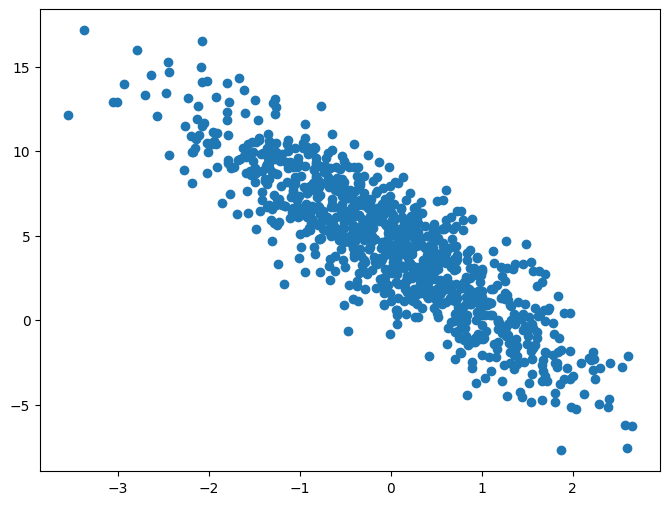

In [4]:
plt.figure(figsize=(8, 6))

x = features[:, 1].detach().numpy()  # 取第二列特征
y = labels.detach().numpy()          # 取标签
plt.scatter(x, y)


In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)  #随机读取
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i : min(i + batch_size, num_examples)])  #从打乱后的索引里，取 batch_size 个样本（min 是为了防止最后一批不足 batch_size 出界）
        yield features[batch_indices], labels[batch_indices]

batch_size = 10;

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break



tensor([[ 1.8965,  0.6064],
        [-0.7266, -1.0071],
        [ 0.2527,  1.0690],
        [-0.2326, -0.2906],
        [-0.5272,  0.8350],
        [-0.7288, -1.1998],
        [-0.3420, -0.7015],
        [-1.3790, -1.7673],
        [ 0.6871,  1.1028],
        [-0.1799,  1.7052]]) 
 tensor([[ 5.9352],
        [ 6.1840],
        [ 1.0695],
        [ 4.7327],
        [ 0.3205],
        [ 6.8191],
        [ 5.9335],
        [ 7.4693],
        [ 1.8372],
        [-1.9701]])


In [6]:
#定义初始化模型参数
w = torch.normal(0, 0.01, size = (2, 1), requires_grad = True)
b = torch.zeros(1, requires_grad = True)

In [7]:
#定义模型
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [8]:
#定义损失函数
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [9]:
#定义优化算法
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():  #在更新参数时，告诉 PyTorch 不要记录梯度计算过程
        for param in params:  #param是参数
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [10]:
#训练过程
lr = 0.03  #lr是学习率
num_epochs = 3  #迭代轮次
net = linreg  #定义的模型
loss = squared_loss  #损失

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) #x和y的小批量损失
        #因为l形状是(batch_size, 1), 而不是一个标量。l中所有元素被加到一起
        #并以此计算[w, b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  #使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
        

epoch 1, loss 0.022997
epoch 2, loss 0.000080
epoch 3, loss 0.000050


In [11]:
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差：tensor([-7.0810e-05, -9.8467e-05], grad_fn=<SubBackward0>)
b的估计误差: tensor([-0.0005], grad_fn=<RsubBackward1>)
